# Random Walk - n-step TD Methods

Ref: RL by Sutton, Barto, Chapter 7, Example 7.1, Pg. 144

# Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym

from tqdm import tqdm

# Define Functions and Classes

## Function: n_step_td

In [2]:
def n_step_td(env, policy, svf_init, num_episodes, n, gamma = 1.0, alpha = 0.5, ret_svf_vs_ep = False):
    """
    Tabular n-step TD algorithm.
    Ref: Section 7.1, Pg. 144 of RL_Sutton
    
    Args:
        env: OpenAI environment.
        policy: Policy to be evaluated
        svf_init: Initial state-value function
        num_episodes: Number of episodes to run for.
        n: Value of 'n' to use in n-step TD.
        gamma: Discount factor.
        alpha: TD learning rate.
        ret_svf_vs_ep: Boolean. If True, return state-value function across episodes
    
    Returns:
        svf: Final state-value function
    """


    svf_vs_ep = [] # Initialize placeholder to store state-value functions across episodes
    svf = svf_init.copy() # Initialize state-value function
    svf_vs_ep.append(svf.copy()) # Append initial state-value function to svf_vs_ep
    
    for ep in range(num_episodes): # Loop through num_episodes

        states_list = [] # Placeholder to store states encountered during the episode
        actions_list = [] # Placeholder to store actions taken during the episode
        rewards_list = [] # Placeholder to store rewards obtained during the episode

        env.reset() # Reset environment
        states_list.append(env.state) # Append current state to states_list
        rewards_list.append(0) # Reward at time-step 0 is '0'
        T = np.inf # Initialize time-stamp of terminal state to infinity

        t = 0 # Initialize current time-stamp
        while(1):
            if (t < T): # Terminal state not-reached
                action = policy(states_list[t]) # Define action based on current policy
                next_state, reward, is_done = env.step(action) # Take action and record Rt+1 and St+1
                rewards_list.append(reward)
                states_list.append(env.state)
                actions_list.append(action)

                if (is_done): # Update T if terminal state is reached
                    T = t + 1

            tau = t - n + 1 # Time-step whose state's estimate is being updated
            if (tau >= 0): # Start update from t = (n - 1)
                G = 0 # Initialize reward
                rew_ind_min = tau + 1 # Start time-step for reward summation
                rew_ind_max = min(tau + n, T) + 1 # Final time-step for reward summation
                for rew_ind in range(rew_ind_min, rew_ind_max, 1):
                    G += (gamma ** (rew_ind - tau -1)) * rewards_list[rew_ind]
                if (tau + n < T): # If reward summation doesn't include terminal time-step
                    G += (gamma ** n) * svf[states_list[tau + n]] # Update G
                svf[states_list[tau]] += alpha * (G - svf[states_list[tau]]) # Perform TD update
            if (tau == T - 1): # Break if no more updates needed
                break
            t += 1 # Move to next time step  
        
        # Update state-value-function across episodes
        if (ret_svf_vs_ep):
            svf_vs_ep.append(svf.copy())
            
    if (ret_svf_vs_ep):
        svf_vs_ep = np.array(svf_vs_ep)
        return svf, svf_vs_ep
    else:
        return svf            

# Define Classes

## Class: RandomWalkLarge1

In [3]:
class RandomWalkLarge1(gym.Env):
    
    '''
    Environment class for 19-state random walk
    Ref: Example 7.1, Pg. 144 of RL by Sutton, Barto
    Reward = -1 for terminating on the left and +1 for terminating on the right
    '''
    
    def __init__(self, num_walk):
        '''
        Arguments:
            num_walk: Number of states in the random walk
        '''
        self.num_walk = num_walk
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Discrete(num_walk + 2)
        self.term_states = [0, num_walk + 1]
        
    def reset(self):
        self.state = int((self.num_walk + 1)/2) # Set reset state to mid-state
        return self.state
    
    def step(self, action):
        if (self.state in self.term_states): # Terminal state
            next_state = self.state
            reward = 0
            is_done = True
        else: # Non-terminal state
            if (action == 0):
                next_state = self.state - 1
            elif (action == 1):
                next_state = self.state + 1
            
            if (next_state == 0): # Left terminal state reached
                reward = -1
                is_done = True
            elif (next_state == self.num_walk + 1): # Right terminal state reached
                reward = 1
                is_done = True
            else:
                reward = 0
                is_done = False
                
        self.state = next_state
        return next_state, reward, is_done      

# Initialize Environment

In [4]:
num_states = 19
env = RandomWalkLarge1(num_states)

# Figure_7P2

**Performance Measure:** Average over 100 repetitions (Average over first 10-episodes (root of mean squared error between predictions at the end of the episode and the true-values for the 19 states))

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [33:22<00:00, 200.24s/it]


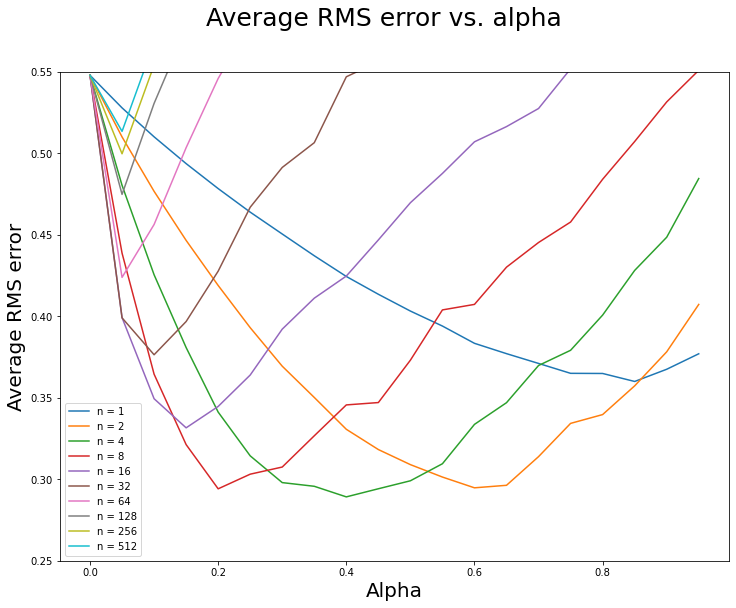

In [5]:
# Code to replicate results in Figure 7.2, Example 7.1, Pg. 145 of RL_Sutton

policy = lambda x: np.random.choice([0, 1]) # Initialize policy to random equiprobable policy
svf_init = np.zeros(num_states + 2) # All states initialized to zeros
n_arr = 2 ** np.arange(0, 10, 1) # Initialize n-array (n = 1, 2, 4, ..., 512)
gamma = 1 # Initialize discount factor
alpha_arr = np.arange(0, 1, 0.05) # Initialize TD update rate
num_episodes = 10 # Number of episodes to run n-step TD over
num_reps = 100 # Number of repetitions to average over
tvf = np.arange(-0.9, 1.0, 0.1) # True-Value evaluated using Bellman equations

fig = plt.figure(figsize = (12, 9))
plt.suptitle('Average RMS error vs. alpha', fontsize = 25)
for n in tqdm(n_arr): # Iterate through all values of n
    avg_rmse_vs_alpha = [] # Averaged rmse for a given alpha
    for alpha in alpha_arr: # Iterate through all values of alpha
        rmse_reps_array = []
        for rep in range(num_reps): # Iterate through num_reps repetitions
            svf, svf_vs_ep = n_step_td(env, policy, svf_init, num_episodes, n, gamma, alpha, True)
            svf_vs_ep = svf_vs_ep[:, 1:20]
            rmse_avg_eps = np.mean(np.sqrt(np.mean(((svf_vs_ep - tvf) ** 2), axis = 1)))
            rmse_reps_array.append(rmse_avg_eps)
        rmse_avg_reps = np.mean(np.array(rmse_reps_array)) # RMSE averaged across episodes and repetitions
        avg_rmse_vs_alpha.append(rmse_avg_reps)
    plt.plot(alpha_arr, avg_rmse_vs_alpha, label = f'n = {n}')

plt.legend(fontsize = 10)
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Average RMS error', fontsize = 20)
plt.ylim(bottom = 0.25, top = 0.55)
plt.show()

**Above plot shows that methods with an intermediate value of n work best**